((7, 0), frozenset({(6, 2), (7, 1), (6, 1), (5, 1), (5, 0), (7, 2), (6, 0), (5, 2)}), (0, 7), frozenset({(2, 7), (1, 5), (0, 6), (1, 7), (2, 6), (0, 5), (1, 6), (2, 5)}), <Turn.WHITE: 1>)
Turn.WHITE


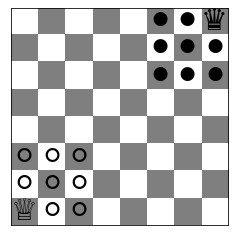

In [1]:
from operator import add
from enum import Enum
import random
import math

import matplotlib.pyplot as plt
import numpy as np

# Positions are defined as a tuple of two elements: (x,y)
# Boards are defined as a tuple of four elements:
# - White queen position
# - White pawns as as set of positions
# - Black queen position
# - Black pawns as as set of positions

class Turn(Enum):
    WHITE = 1
    BLACK = 2

class Board:
    
    def __init__(self):
        self.white_pawns = frozenset(x for x in [(5,0),(5,1),(5,2),(6,0),(6,1),(6,2),(7,1),(7,2)])
        self.white_queen = (7,0)
        self.white_queen_shield = set(x for x in [(6,0),(6,1),(7,1)])
        self.black_pawns = frozenset(x for x in [(0,5),(0,6),(1,5),(1,6),(1,7),(2,5),(2,6),(2,7)])
        self.black_queen = (0,7)
        self.black_queen_shield = set(x for x in [(0,1),(1,1),(1,0)])
        self.turn = Turn.WHITE

    @staticmethod
    def winning_position(board):
        if board[0] == (0,7):
            return (1,0)
        if board[2] == (7,0):
            return (0,1)
        return (0,0)
    
    @staticmethod
    def draw_board(b):

        # Create board and colors
        board = np.zeros((8,8,3))
        board += 0.5 
        board[::2, ::2] = 1 
        board[1::2, 1::2] = 1

        _, ax = plt.subplots()
        ax.imshow(board, interpolation='nearest')

        white_queen = b[0]
        ax.text(white_queen[1], white_queen[0], u'\u2655', size=30, ha='center', va='center')

        for y, x in b[1]:
            ax.text(x, y, u'\u26aa', size=30, ha='center', va='center')

        black_queen = b[2]
        ax.text(black_queen[1], black_queen[0], u'\u265b', size=30, ha='center', va='center')

        for y, x in b[3]:
            ax.text(x, y, u'\u26ab', size=30, ha='center', va='center')

        ax.set(xticks=[], yticks=[])
        ax.axis('image')

        print(b)
        print(b[4])

        plt.show()

    def get_board(self):
        return (self.white_queen,self.white_pawns,self.black_queen, self.black_pawns, self.turn)

    def update_queen_shield(self, queen_position):
        moves = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
        return set([ tuple(map(add, move, queen_position)) for move in moves])
    
    def current_positions(self):
        return (self.white_positions, self.black_positions)
    
    def white_pawn_moves(self, pawn):

        moves = []
        
        if pawn[0] > 0:
            moves.append((pawn[0] - 1, pawn[1]))
        if pawn[1] < 7:
            moves.append((pawn[0], pawn[1] + 1))
            
        return moves
    
    def black_pawn_moves(self, pawn):
        
        moves = []
        
        if pawn[0] < 7:
            moves.append((pawn[0] + 1, pawn[1]))
        if pawn[1] > 0:
            moves.append((pawn[0], pawn[1] - 1))
            
        return moves
    
    def pawn_moves(self, pawn, turn):

        moves = []

        if turn == Turn.WHITE:
            if pawn[0] > 0:
                moves.append((pawn[0] - 1, pawn[1]))
            if pawn[1] < 7:
                moves.append((pawn[0], pawn[1] + 1))
        else:
            if pawn[0] < 7:
                moves.append((pawn[0] + 1, pawn[1]))
            if pawn[1] > 0:
                moves.append((pawn[0], pawn[1] - 1))

        return moves

    def queen_moves(self, board):

        boards = []

        white_queen = board[0]
        white_pawns = board[1]
        white_queen_shield = self.update_queen_shield(white_queen)
        black_queen = board[2]
        black_pawns = board[3]
        black_queen_shield = self.update_queen_shield(black_queen)
        turn = board[4]

        newturn = Turn.BLACK if board[4] == Turn.WHITE else Turn.WHITE

        if turn == Turn.WHITE:
            queen = white_queen
            your_pawns = white_pawns
            opponent_pawns = black_pawns
            directions = [(-1,0),(0,1)]
            opponent_queen_shield = black_queen_shield
        else:
            queen = black_queen        
            your_pawns = black_pawns
            opponent_pawns = white_pawns
            directions = [(1,0),(0,-1)]
            opponent_queen_shield = white_queen_shield

        for direction in directions:
            
            x_move = direction[0] + queen[0]
            y_move = direction[1] + queen[1]

            while (x_move,y_move) in your_pawns:

                x_move = direction[0] + x_move
                y_move = direction[1] + y_move

            queen_shield = self.update_queen_shield((x_move, y_move))

            if  0 <= x_move <= 7 and \
                0 <= y_move <= 7 and \
                (x_move, y_move) not in opponent_pawns and \
                len(queen_shield.intersection(opponent_pawns)) == 0 and \
                len(queen_shield.intersection(opponent_queen_shield)) == 0:
                    if turn == Turn.WHITE:
                        boards.append(((x_move,y_move),white_pawns,black_queen,black_pawns, newturn))
                    else:
                        boards.append((white_queen,white_pawns,(x_move,y_move),black_pawns, newturn))

        return boards
    
    def next_boards(self, board):
        
        boards = []
        
        white_queen = board[0]
        white_pawns = board[1]
        white_queen_shield = self.update_queen_shield(white_queen)
        black_queen = board[2]
        black_pawns = board[3]
        black_queen_shield = self.update_queen_shield(black_queen)
        turn = board[4]
        
        newturn = Turn.BLACK if board[4] == Turn.WHITE else Turn.WHITE
        
        if turn == Turn.WHITE:
            for pawn in white_pawns:    
                pawn_moves = self.white_pawn_moves(pawn)
                for pawn_move in pawn_moves:
                    if  pawn_move != (0,7) and \
                        pawn_move not in white_pawns and \
                        pawn_move != white_queen and \
                        pawn_move not in black_queen_shield:
                            
                            new_white_pawns = white_pawns.copy()
                            new_black_pawns = black_pawns.copy() 
                            
                            if pawn_move in black_pawns:
                                tmp_list = list(new_black_pawns)
                                if pawn_move in tmp_list: tmp_list.remove(pawn_move)
                                new_black_pawns = frozenset(tmp_list)
                            
                            tmp_list = list(new_white_pawns)
                            tmp_list.remove(pawn)
                            tmp_list.append(pawn_move)
                            new_white_pawns = frozenset(tmp_list)
                    
                            boards.append((white_queen,new_white_pawns,black_queen,new_black_pawns,newturn))
        else:
            for pawn in black_pawns:    
                pawn_moves = self.black_pawn_moves(pawn)
                for pawn_move in pawn_moves:
                    if  pawn_move != (7,0) and \
                        pawn_move not in black_pawns and \
                        pawn_move != black_queen and \
                        pawn_move not in white_queen_shield:
                            
                            new_black_pawns = black_pawns.copy()
                            new_white_pawns = white_pawns.copy() 
                            
                            if pawn_move in white_pawns:
                                tmp_list = list(new_white_pawns)
                                if pawn_move in tmp_list: tmp_list.remove(pawn_move)
                                new_white_pawns = frozenset(tmp_list)
                            
                            tmp_list = list(new_black_pawns)
                            tmp_list.remove(pawn)
                            tmp_list.append(pawn_move)
                            new_black_pawns = frozenset(tmp_list)
                    
                            boards.append((white_queen,new_white_pawns,black_queen,new_black_pawns,newturn))
        
        boards = boards + self.queen_moves(board)
        return boards
    
    def simulate(self, board):

        while (result := Board.winning_position(board)) == (0,0):

            next_moves = self.next_boards(board)
            
            if len(next_moves) == 0:
                return (0,0)

            board = random.choice(next_moves)

        return result 
        
b = Board()
Board.draw_board(b.get_board())

((7, 0), {(7, 1), (5, 0), (7, 2), (6, 0), (6, 1), (5, 1), (5, 2)}, (0, 7), {(2, 7), (1, 5), (0, 6), (1, 7), (2, 6), (0, 5), (1, 6), (2, 5)}, <Turn.BLACK: 2>)
Turn.BLACK


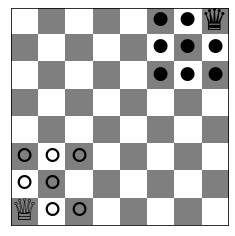

In [10]:
b3 =   ((7, 0), {(5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (5, 2), (7, 1), (7, 2)}, (0, 7), {(0, 5), (0, 6), (1, 5), (1, 6), (1, 7), (2, 5), (2, 6), (2, 7)} , Turn.BLACK)

b.draw_board(b3)

((7, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), <Turn.BLACK: 2>)
Turn.BLACK


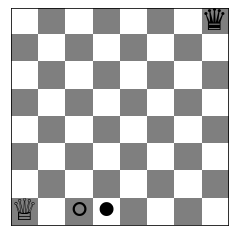

((7, 0), frozenset(), (0, 7), frozenset({(7, 2)}), <Turn.WHITE: 1>)
((7, 0), frozenset(), (0, 7), frozenset({(7, 2)}), <Turn.WHITE: 1>)
Turn.WHITE


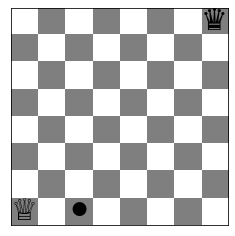

((7, 0), frozenset({(7, 2)}), (1, 7), frozenset({(7, 3)}), <Turn.WHITE: 1>)
((7, 0), frozenset({(7, 2)}), (1, 7), frozenset({(7, 3)}), <Turn.WHITE: 1>)
Turn.WHITE


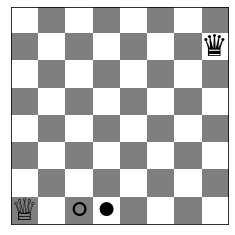

((7, 0), frozenset({(7, 2)}), (0, 6), frozenset({(7, 3)}), <Turn.WHITE: 1>)
((7, 0), frozenset({(7, 2)}), (0, 6), frozenset({(7, 3)}), <Turn.WHITE: 1>)
Turn.WHITE


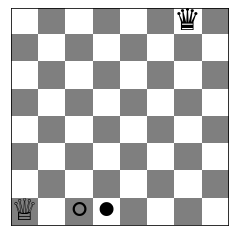

In [6]:
b2 = ((7, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), Turn.BLACK)

b.draw_board(b2)

# for board in b.next_boards(b2):
#     print(board)
#     b.draw_board(board)


In [4]:
white_wins = 0
black_wins = 0
draws = 0
    
for i in range(50000):
    result = b.simulate(b.get_board())
    if result == (1,0):
        white_wins += 1
    elif result == (0,1):
        black_wins += 1
    else:
        draws += 1

print("Black wins: {}".format(black_wins))
print("White wins: {}".format(white_wins))
print("Draws: {}".format(draws))

Black wins: 17242
White wins: 17889
Draws: 14869


In [5]:
from collections import defaultdict

class MCTS:
    
    def __init__(self, board, sims=200):
        self.children = defaultdict(list)
        self.Q = defaultdict(int)
        self.N = defaultdict(int)
        self.board = board
        self.sims = sims

    def best_move(self, board):
        
        for _ in range(self.sims):
            self.iterate(board)

        def score(n):
            if self.N[n] == 0:
                return float("-inf") 
            return self.Q[n] / self.N[n]
        
        return max(self.children[board], key=score)
    
    def iterate(self, board):
         
         path = []
         
         # select
         path = self.selection(board)
         node = path[-1]

         # expand
         self.children[node] = self.board.next_boards(node)

         # simulate
         result = self.board.simulate(node)
         
         # backpropagate
         for step in path:
            
            self.N[step] +=1

            if step[4] == Turn.BLACK:
                self.Q[step] += result[0]
            else:
                self.Q[step] += result[1]
    
    def selection(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self.uct(node)
    
    def uct(self, node):

        log_N = math.log(self.N[node])

        def _uct(n):
            return self.Q[n] / self.N[n] + math.sqrt(
                log_N / self.N[n]
            )
        return max(self.children[node], key=_uct)
        

In [10]:
b = Board()

mcts_white = MCTS(b, sims=5)
mcts_black = MCTS(b, sims=100)

best_move = b.get_board()

while (result := Board.winning_position(best_move)) == (0,0):
    if best_move[4] == Turn.WHITE:
        best_move = mcts_white.best_move(best_move)
    else:
        best_move = mcts_black.best_move(best_move)


b.draw_board(best_move)

ValueError: max() arg is an empty sequence

In [13]:
board = ((0, 7), frozenset({(0, 4), (5, 7), (0, 6), (1, 7), (4, 1), (4, 7)}), (2, 0), frozenset({(7, 6), (5, 0), (7, 2), (6, 0), (1, 0)}), Turn.BLACK)

((7, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), <Turn.BLACK: 2>)
Turn.BLACK


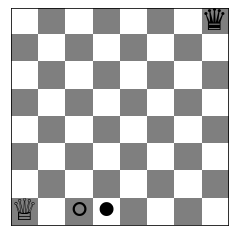

next boards
((7, 0), frozenset(), (0, 7), frozenset({(7, 2)}), <Turn.WHITE: 1>)
Turn.WHITE


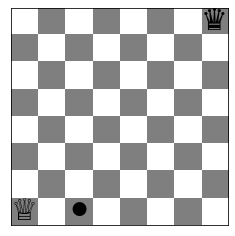

((7, 0), frozenset({(7, 2)}), (1, 7), frozenset({(7, 3)}), <Turn.WHITE: 1>)
Turn.WHITE


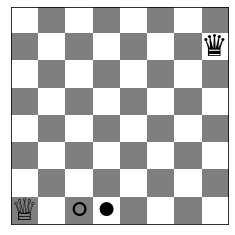

((7, 0), frozenset({(7, 2)}), (0, 6), frozenset({(7, 3)}), <Turn.WHITE: 1>)
Turn.WHITE


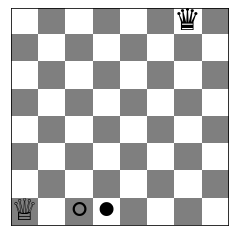

In [11]:
example = ((7, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), Turn.BLACK)
b.draw_board(example)

print('next boards')

b = Board()
for board in b.next_boards(example):
    b.draw_board(board)

((7, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), <Turn.WHITE: 1>)
Turn.WHITE


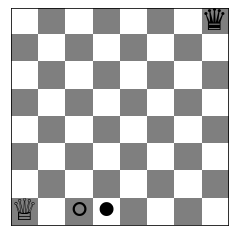

next boards
((7, 0), frozenset({(6, 2)}), (0, 7), frozenset({(7, 3)}), <Turn.BLACK: 2>)
Turn.BLACK


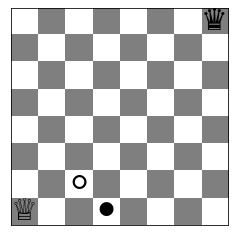

((7, 0), frozenset({(7, 3)}), (0, 7), frozenset(), <Turn.BLACK: 2>)
Turn.BLACK


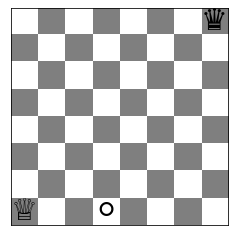

((6, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), <Turn.BLACK: 2>)
Turn.BLACK


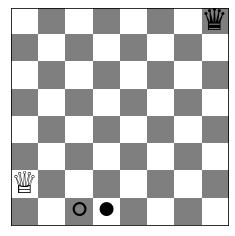

((7, 1), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), <Turn.BLACK: 2>)
Turn.BLACK


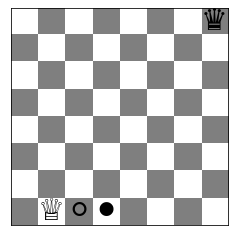

In [10]:
example = ((7, 0), frozenset({(7, 2)}), (0, 7), frozenset({(7, 3)}), Turn.WHITE)
b.draw_board(example)

print('next boards')

b = Board()
for board in b.next_boards(example):
    b.draw_board(board)

In [5]:
board = ((6, 4), frozenset({(1, 4), (0, 6), (1, 7), (1, 6), (1, 3), (3, 5)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), Turn.BLACK)

In [8]:
b = Board()
#Board.draw_board(b.get_board())

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


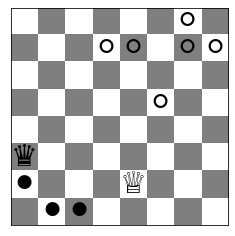

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


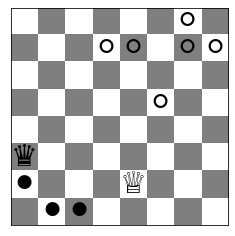

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


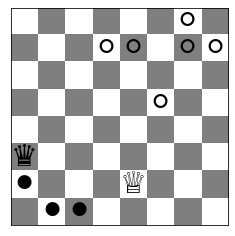

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


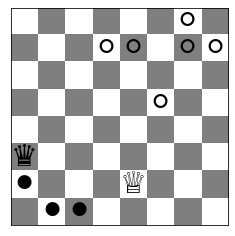

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


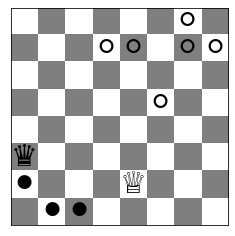

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


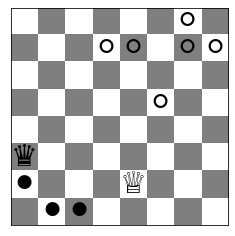

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


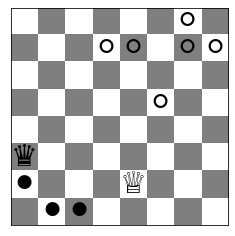

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.BLACK: 2>)
Turn.BLACK


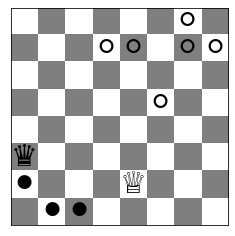

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (7, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.WHITE: 1>)
Turn.WHITE


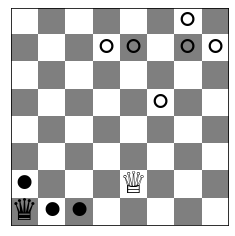

((6, 4), frozenset({(1, 7), (1, 6), (1, 3), (3, 5), (1, 4), (0, 6)}), (7, 0), frozenset({(7, 1), (7, 2), (6, 0)}), <Turn.WHITE: 1>)
Turn.WHITE


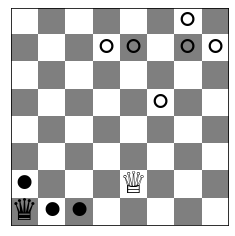

In [27]:
board = ((6, 4), frozenset({(1, 4), (0, 6), (1, 7), (1, 6), (1, 3), (3, 5)}), (5, 0), frozenset({(7, 1), (7, 2), (6, 0)}), Turn.BLACK)

b = Board()

mcts = MCTS(b, sims=10)
best_move = board

while (result := Board.winning_position(best_move)) == (0,0):
    best_move = mcts.best_move(best_move)
    b.draw_board(best_move)